## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [15]:
from nndl import Softmax

In [16]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

## Answer:

When we initialize the weight matrix, it is randomly selected with unifrom matrix, which means the predicted probability of each class is also uniform distribution and approximatly equals 1/10. That means the cross entropy for each example is -log(0.1), which is 2.3025 (approximatly equals to the loss).

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.811560 analytic: 0.811560, relative error: 1.287581e-09
numerical: 0.133042 analytic: 0.133042, relative error: 4.391477e-08
numerical: 1.459821 analytic: 1.459821, relative error: 1.281714e-10
numerical: 0.705703 analytic: 0.705703, relative error: 1.394274e-08
numerical: 0.516723 analytic: 0.516723, relative error: 8.749868e-08
numerical: 1.715495 analytic: 1.715495, relative error: 1.919600e-08
numerical: -0.336979 analytic: -0.336979, relative error: 1.138216e-07
numerical: 0.526789 analytic: 0.526789, relative error: 1.425703e-08
numerical: 0.398616 analytic: 0.398616, relative error: 1.296090e-08
numerical: -3.990390 analytic: -3.990390, relative error: 1.198945e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.30447519497518 / 331.2038773428697 computed in 0.16248798370361328s
Vectorized loss / grad: 2.3044751949751823 / 331.20387734286965 computed in 0.02423405647277832s
difference in loss / grad: -2.220446049250313e-15 /2.2241223160084674e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The gradient descent training step of softmax and svm are quiet similar, except they use different loss functions.

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981614
iteration 500 / 1500: loss 1.862265307354135
iteration 600 / 1500: loss 1.8532611454359382
iteration 700 / 1500: loss 1.835306222372583
iteration 800 / 1500: loss 1.829389246882764
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.97835035402523
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 12.624136924743652s


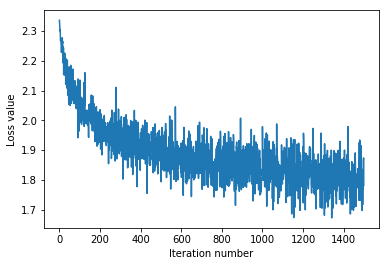

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [18]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [5e-3, 5.5e-3, 6e-3, 6.5e-3, 7e-3, 7.5e-3, 8e-3, 8.3e-3, 8.5e-3, 9.5e-3, 1e-4, 5e-4, 1e-5]
training_accuracies = []
validation_accuracies = []

for lr_rate in learning_rates:
    loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, num_iters=1500, verbose=True)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    training_accuracies.append(np.mean(np.equal(y_train,y_train_pred)))
    validation_accuracies.append(np.mean(np.equal(y_val, y_val_pred)))

(best_val_acc,i) = max((v,i) for i,v in enumerate(validation_accuracies))
best_lr_rate = learning_rates[i]

#print(validation_accuracies)
print('The best learning rate is: {} , with validation accuracies: {}'.format(best_lr_rate, best_val_acc))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


iteration 0 / 1500: loss 2.3272060846682603
iteration 100 / 1500: loss 2.070796610909686
iteration 200 / 1500: loss 1.9919267217995216
iteration 300 / 1500: loss 1.935776136240207
iteration 400 / 1500: loss 1.9322690223589751
iteration 500 / 1500: loss 1.8177236818686637
iteration 600 / 1500: loss 1.853576327586231
iteration 700 / 1500: loss 1.8976491006525829
iteration 800 / 1500: loss 2.0080505025566153
iteration 900 / 1500: loss 1.7555417448535748
iteration 1000 / 1500: loss 1.8163058236132195
iteration 1100 / 1500: loss 1.823860682516186
iteration 1200 / 1500: loss 1.7434754112412105
iteration 1300 / 1500: loss 1.779670340476944
iteration 1400 / 1500: loss 1.794696055405351
iteration 0 / 1500: loss 2.399650633497909
iteration 100 / 1500: loss 2.082333781114565
iteration 200 / 1500: loss 2.0139932119600807
iteration 300 / 1500: loss 1.9194168504289868
iteration 400 / 1500: loss 1.9598471567748568
iteration 500 / 1500: loss 1.8612610643110696
iteration 600 / 1500: loss 1.876152131275

iteration 1400 / 1500: loss 1.7939004361352382
iteration 0 / 1500: loss 2.315583636919492
iteration 100 / 1500: loss 1.9705528812912438
iteration 200 / 1500: loss 2.0148606160089817
iteration 300 / 1500: loss 1.9910339826950756
iteration 400 / 1500: loss 1.9873403589290382
iteration 500 / 1500: loss 1.8810894485509322
iteration 600 / 1500: loss 1.9467590137739097
iteration 700 / 1500: loss 1.860571926293982
iteration 800 / 1500: loss 1.7779461475601728
iteration 900 / 1500: loss 1.8196869376462304
iteration 1000 / 1500: loss 1.9370261157711133
iteration 1100 / 1500: loss 1.7892284619816894
iteration 1200 / 1500: loss 1.8701940734050146
iteration 1300 / 1500: loss 1.813007591447041
iteration 1400 / 1500: loss 1.9549175867075406
[0.407, 0.378, 0.387, 0.391, 0.386, 0.387, 0.397, 0.386, 0.387, 0.398, 0.381, 0.399, 0.376]
The best learning rate is: 0.005 , with validation accuracies: 0.407
